In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [3]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

number of all smiles:  10839
number of successfully processed smiles:  10839


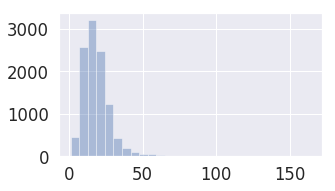

In [4]:
task_name = '500_toxic'
tasks = ['500_toxic']
raw_filename = "../data/500_toxic/total_500_1.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [5]:
smiles_tasks_df

,500_toxic,smiles,cano_smiles
0,0,C=1(C(=C(C(C=1Cl)(C2(C(=C(C(=C2Cl)Cl)Cl)Cl)Cl)...,ClC1=C(Cl)C(Cl)(C2(Cl)C(Cl)=C(Cl)C(Cl)=C2Cl)C(...
1,1,C13(C4(C2(C5(C(C1(C2(Cl)Cl)Cl)(C3(C(C45Cl)(Cl)...,ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...
2,1,O=P(OC(=CBr)c1ccc(cc1Cl)Cl)(OC)OC,COP(=O)(OC)OC(=CBr)c1ccc(Cl)cc1Cl
3,0,O=C(OC)C(Cc1ccc(cc1)Cl)Cl,COC(=O)C(Cl)Cc1ccc(Cl)cc1
4,0,O=C(O)CCCOc1ccc(cc1Cl)Cl,O=C(O)CCCOc1ccc(Cl)cc1Cl
...,...,...,...
10834,0,O=C1OC(CCCCCCCCCCC)CC(O)C1CCCCCC,CCCCCCCCCCCC1CC(O)C(CCCCCC)C(=O)O1
10835,0,O(C)[Si](OC)(OC)CC(C)C,CO[Si](CC(C)C)(OC)OC
10836,0,O=S(=O)(N)c1cc2c(cc1Cl)NC(NS2(=O)(=O))C(c3cccc...,CC(c1ccccc1)C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=...
10837,0,O=C(OCCNC(C)(C)C)C(=C)C,C=C(C)C(=O)OCCNC(C)(C)C


In [6]:
random_seed = 188
random_seed = int(time.time())
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.1
fingerprint_dim = 150

radius = 3
T = 2
weight_decay = 2.9 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [7]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>100]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,500_toxic,smiles,cano_smiles
7838,0,C,C


In [9]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])
    
test_df=remained_df.tail(2579)
training_data = remained_df.drop(test_df.index) # training data


# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/5, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)



In [12]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

649206
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([150, 150])
attend.0.bias torch.Size([150])
attend.1.weight torch.Size([150, 150])
attend.1.bias torch.Size([150])
attend.2.weight torch.Size([150, 150])

In [13]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)            
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     test_prc = auc(recall, precision)
    test_precision = [precision_score(y_val_list[i],
                                     (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_recall = [recall_score(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()
    
    return test_roc, test_prc, test_precision, test_recall, test_loss


In [14]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_prc, train_precision, train_recall, train_loss = eval(model, train_df)
    valid_roc, valid_prc, valid_precision, valid_recall, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.81:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
#         +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
#         +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
        break
        
    train(model, train_df, optimizer, loss_function)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


EPOCH:	0
train_roc:[0.5332027356992108]
valid_roc:[0.5206467285574606]

EPOCH:	1
train_roc:[0.6314981278977212]
valid_roc:[0.5973106736419809]

EPOCH:	2
train_roc:[0.672982733645134]
valid_roc:[0.6260838448899775]

EPOCH:	3
train_roc:[0.7191423406928137]
valid_roc:[0.6750017639884283]

EPOCH:	4
train_roc:[0.7344964716491897]
valid_roc:[0.6927152317880795]

EPOCH:	5
train_roc:[0.738472559784524]
valid_roc:[0.6961524892396705]

EPOCH:	6
train_roc:[0.7483814105912198]
valid_roc:[0.7107663773725643]

EPOCH:	7
train_roc:[0.7474276827207774]
valid_roc:[0.711007287792192]

EPOCH:	8
train_roc:[0.7500280286765201]
valid_roc:[0.7127168445774995]

EPOCH:	9
train_roc:[0.7526140387563035]
valid_roc:[0.7152962996562742]

EPOCH:	10
train_roc:[0.752689231523644]
valid_roc:[0.7185873980666687]

EPOCH:	11
train_roc:[0.7561838287178401]
valid_roc:[0.7204783936617376]

EPOCH:	12
train_roc:[0.7611430693442947]
valid_roc:[0.7280191921940992]

EPOCH:	13
train_roc:[0.7567827044463739]
valid_roc:[0.72619069218

In [37]:
def pred(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    smiles_list=[]
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list.extend(batch_df.cano_smiles.values.tolist())
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values
            
            if len(y_val) == 0:
                continue
            y_val_adjust= np.array(y_val).astype(float)
            y_pred_adjust=y_pred
            loss = loss_function[i](
                y_pred,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            #a=list(y_val_list[0].values())
            #b=list(y_pred_list[0].values())
            #print(len(a[0]))
            #print(len(b[0]))
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)  
            #c=list(y_val_list[0].values())
            #d=list(y_pred_list[0].values())
            #print(len(c[0]))
            #print(len(d[0]))          
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     test_prc = auc(recall, precision)
    test_precision = [precision_score(y_val_list[i],
                                     (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_recall = [recall_score(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()
    
    return test_roc, test_prc, test_precision, test_recall, test_loss, y_val_list, y_pred_list,smiles_list
    


In [38]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()

test_df=pd.read_csv('test_500_2581.csv')


test_roc, test_prc, test_precision, test_recall, test_loss, y_val_list, y_pred_list,smiles_list1= pred(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:382
test_roc:[0.8291946370156325]
test_roc_mean: 0.8291946370156325


In [44]:
test_df

,500_toxic,smiles,cano_smiles
0,1,N#CC(OC(=O)C1C(C=C(Cl)Cl)C1(C)(C))c3nc(Oc2cccc...,CC1(C)C(C=C(Cl)Cl)C1C(=O)OC(C#N)c1cccc(Oc2cccc...
1,0,Oc1cc(c(c(c1)C)Cl)C,Cc1cc(O)cc(C)c1Cl
2,0,O=C(Oc1ccc(cc1)C(c2ncccc2)c3ccc(OC(=O)C)cc3)C,CC(=O)Oc1ccc(C(c2ccc(OC(C)=O)cc2)c2ccccn2)cc1
3,0,O=C(OC)C=Cc1ccccc1,COC(=O)C=Cc1ccccc1
4,0,OC(c1ccc2ccccc2(c1))CNC(C)C,CC(C)NCC(O)c1ccc2ccccc2c1
...,...,...,...
2574,0,O=C1OC(CCCCCCCCCCC)CC(O)C1CCCCCC,CCCCCCCCCCCC1CC(O)C(CCCCCC)C(=O)O1
2575,0,O(C)[Si](OC)(OC)CC(C)C,CO[Si](CC(C)C)(OC)OC
2576,0,O=S(=O)(N)c1cc2c(cc1Cl)NC(NS2(=O)(=O))C(c3cccc...,CC(c1ccccc1)C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=...
2577,0,O=C(OCCNC(C)(C)C)C(=C)C,C=C(C)C(=O)OCCNC(C)(C)C


In [40]:
len(smiles_list1)

2579

In [41]:
a=list(y_val_list[0])
b=list(y_pred_list[0])
print(len(a))
print(len(b))

2579
2579


In [42]:
best_param

{'roc_epoch': 382,
 'loss_epoch': 364,
 'valid_roc': 0.8204675473905838,
 'valid_loss': 0.5261324}

In [43]:
from sklearn.metrics import r2_score  
from sklearn.metrics import balanced_accuracy_score

y_pred_final=list(map(lambda x: 0 if x<=0.5 else 1,list(y_pred_list[0])))
y_true=list(y_val_list[0])
balanced_accuracy_score(y_true,y_pred_final)

0.7467027024743462

In [48]:
df_result=pd.DataFrame(columns=['smiles','true','predict'])
df_result['smiles']=smiles_list
df_result['true']=y_val_list[0]
df_result['predict']=y_pred_list[0]

In [49]:
df_result

,smiles,true,predict
0,CC1(C)C(C=C(Cl)Cl)C1C(=O)OC(C#N)c1cccc(Oc2cccc...,1.0,0.915394
1,Cc1cc(O)cc(C)c1Cl,0.0,0.266421
2,CC(=O)Oc1ccc(C(c2ccc(OC(C)=O)cc2)c2ccccn2)cc1,0.0,0.264353
3,COC(=O)C=Cc1ccccc1,0.0,0.124869
4,CC(C)NCC(O)c1ccc2ccccc2c1,0.0,0.561504
...,...,...,...
2574,CCCCCCCCCCCC1CC(O)C(CCCCCC)C(=O)O1,0.0,0.177991
2575,CO[Si](CC(C)C)(OC)OC,0.0,0.020401
2576,CC(c1ccccc1)C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=...,0.0,0.243841
2577,C=C(C)C(=O)OCCNC(C)(C)C,0.0,0.829588
